# Convolutional Neural Network

Diese Woche beschäftigen wir uns mit Convolutional Neuroal Network. Convolution Neural Networks (CNN) werden vorallem, aber nicht außschließlich, für die Bilderkennung benutzt.

Anders als Neuronale Netzwerke die wir bis jetzt kennen gelernt haben, können CNNs Bilder als eine Matrix einlesen. Das bedeutet lokale Zusammenhängen werden nicht durch das `flatten` der Bilder gebrochen.  

![](https://miro.medium.com/max/1280/1*h01T_cugn22R2zbKw5a8hA.gif)

<centering><h7> Otavio Good. 2017 "A Visual and Intuitive Understanding of Deep Learning" *O'Reilly AI Conference* </h7></centering>

In [219]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.utils import data

def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Zunächst laden Sie wieder die Trainingsdaten ein und konvertieren Sie zu einem Tensor. Insgesamt sind es 60,000 Bilder und 784 Pixel + eine Spalte für die Labels der Bilder. 

In [220]:
train_data = np.genfromtxt('../data/mnist/mnist_train.csv', delimiter=',', skip_header =False)

train_x = torch.tensor(min_max(train_data[:,1:]), dtype=torch.float32)
train_y = torch.tensor(train_data[:,0], dtype=torch.long)

print(train_x.shape, train_y.shape)

torch.Size([60000, 784]) torch.Size([60000])


Bisher haben wir Bilder immer als 1D Input in unsere Neuronales Netzwerk eingeführt. Wir wollen diesmal aber die 2D Struktur benutzen. Dafür müssen wir aus einem Vektor der Länge `784` eine Matrix mit den Maßen `28 x 28` machen.

Hierfür können Sir die Funktion `vektor.view(28,28)` benutzen.

In [221]:
train_x[0,:].view(28,28).shape

torch.Size([28, 28])

Wir können uns dieses Bild anschauen, können aber nicht viel erkennen. 

In [218]:
train_x[0,:].view(28,28)

RuntimeError: shape '[28, 28]' is invalid for input of size 4096

Doch mithilfe von `matplotlib` können wir Arrays als Bild darstellen. `cmap = "greys"` gibt hierbei an, dass wir unser Farbspektrum nur in Schwarz-Weiß haben wollen.

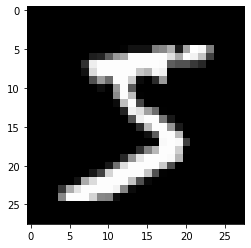

In [222]:
plt.imshow(train_x[0,:].view(28,28), cmap= "gray")

Wir haben bis jetzt nur ein Bild in das richtige Format gebracht, um das für all Bilder zu machen, können wir auch `.view()` benutzen. Der Tensor von oben hatte den Format `(Höhe,Breite)`. Damit wir alle Bilder konvertieren können, müssen wir den `tensor` um eine extra Dimension erweitern.  Der neue `tensor` sollte die folgenden Dimensionen `(Anzahl Bilder, Höhe, Breite)` haben. Wir haben also insgesamt drei Dimensionen.

Allerdings würde hier PyTorch einen Strich durch die Rechnung machen. Denn PyTorch kann sowohl mit Schwarz-Weiß (s/w),  als auch mit farbigen Bildern arbeiten. In PyTorch werden farbige Bilder über drei Matrizen dargestellt. Eine für Rot, eine für Grün und eine für Blau. Diese werden auch als Channel bezeichnet. Ein farbiges Bild würde in PyTorch die Dimensionen `(3, Höhe, Breite)` haben. Die Dimension, die wir gerade noch für die `Anzahl Bilder` verwendet haben, ist also mit der `Anzahl Channels` belegt.


![](https://miro.medium.com/max/700/1*icINeO4H7UKe3NlU1fXqlA.jpeg)

<center><h7>Source: Mathanraj Sharma, 2019 </h7></center>

PyTorch erwartet diese "Channel Dimension" auch für s/w Bilder. 
Deshalb stellen wir ein s/w Bild wie folgt dar: `(1, Höhe, Breite)`. 

Daraus folgt, dass alle Bilder vom MNIST Datensatz diesem Format entsprechen müssen: `(Anzahl Bilder, 1, Höhe, Breite)`. Also insgesamt hat unser Input Tensor 4 Dimensionen.



Konvertieren Sie `train_x` in dieses Format.

In [ ]:
train_x = train_x.view(_____,1,____,____)
train_x.shape

<details>
<summary><b>Lösung:</b></summary>
    
```python 
train_x = train_x.view(60000,1,28,28)
```
</details>

Sie haben jetzt alle Bilder in das Format `(1,28,28)` konvertiert.
Bilder können Sie sich immer noch mit `plt.imshow` anzeigen lassen.

Beachten Sie, wie jetzt der Tensor indiziert ist. `[0,0,:,:]`. Wir wählen das erste Bild aus, und auch den ersten und einzigen Channel. Wir wählen die gesamte Höhe und Breite aus, um das Bild komplett darzustellen.

In [ ]:
plt.imshow(train_x[0,0,:,:], cmap= "gray")

Wie letzte Woche können Sie sich auch diesmal einen `DataLoader` benutzen. Dafür müssen Sie erst ein TensorDataset erstellen. Mit `next(iter())` können Sie sich den ersten Batch des Dataloaders ausgeben lassen.

In [ ]:
torch_train = data.TensorDataset(_____, ____)
train_loader = data.DataLoader(______, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)

<details>
<summary><b>Lösung:</b></summary>
    
```python 
torch_train = data.TensorDataset(train_x,train_y)
train_loader = data.DataLoader(torch_train, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)
```
</details>

Wie Sie sehen können, hat der `batch_x` die Dimensionen `[32, 1, 28, 28]`. Also `32` Bilder, die Größe unseres Batches, `1`Channel, `28` Pixel in der Höhe und `28` in der Breite.

## CNNs in PyTorch erstellen.

Wir haben so weit unsere Daten im richtigen Format, jetzt beschäftigen wir uns mit dem Erstellen von `CNN` in PyTorch. Sowie es `linear` layers in PyTorch gibt, gibt es auch Convolutional Layers im `nn` Modul.

`nn.Conv2d()` ist so eine Layer. Bevor wir Sie benutzen, besprechen wir kurz die wichtigsten Parameter.

- `in_channels` die Anzahl der Channels, die das Bild vor der Convolution hat 
- `out_channels` wie viel Channels soll, das Bild nach der Convolution haben oder auch wie viele Filter lassen wir über das Bild laufen.
- `kernel_size` wie groß ist der Kernel, also die Höhe/Breite in Pixeln



In [ ]:
conv1 = conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

In [ ]:
out = conv1(batch_x)
out.shape

Sie sehen, der Batch hat sich in der Größe verändert. Zunächst haben wir immer noch `32` Bilder, allerdings wie spezifiziert, haben wir jetzt `3` Channel. Auch die Höhe und Breite unseres Bildes hat sich verändert. Wir haben jeweils 2 Pixel pro Dimension verloren. Das liegt daran, wie Convolutions funktionieren.

![](https://miro.medium.com/max/700/1*L4T6IXRalWoseBncjRr4wQ@2x.gif)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Hier sehen an einem Beispiel, warum bei einer Kernel Size von 3 unser Output Bild um zwei Pixel kleiner wird. Links ist das Inputbild und rechts der Output. Da wir den Kernel nicht über den Rand des Bildes schieben können, „verlieren“ wir den äußern Rand des Bildes.

Um zu verhindern, dass diese Information verloren geht, können wir das Bild *padden*. Dadurch vergrößern wir das Bild, zum Beispiel mit Pixel, die den Wert Null haben.
![](https://miro.medium.com/max/700/1*W2D564Gkad9lj3_6t9I2PA@2x.gif)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Durch das Padding, kann der Kernel einmal über das ganze Bild geschoben werden.
Wir können die Breite des Paddings auch als Parameter in `Conv2d` mitgeben.

In [223]:
conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding =1)
out = conv1(batch_x)
out.shape

torch.Size([32, 3, 64, 64])

Durch das Padding schrumpft nun das Bild nicht mehr. Dadurch, dass wir jetzt `3` Channel haben, können wir das Bild immer noch mit `plt.imshow` darstellen.  Hierzu müssen wir ein Bild aus dem Batch auswählen und mit dem Befehl `detach()` die Gradienten, die durch `autograd` gespeichert werden, entfernen.

*Ein solches Bild, kann man nur als Beispiel benutzen um die Transformation zu verdeutlichen. Die tatsächlichen Farben und Intensitäten sind hier aber irrelevant, da Sie von dem Netzwerk arbiträr gewählt sind. Zum Beispiel, gibt die Reihenfolge der Channels an, welcher Channel für welche Farbe zuständig ist. Ein Convolution ist sich natürlich nicht bewusst, dass es so eine Ordnung in den Channels gibt.*

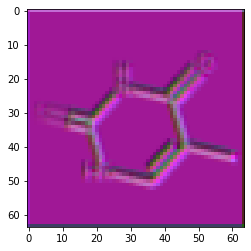

In [224]:
plt.imshow(min_max(out.detach().numpy()[0].transpose((1, 2, 0))))

Sie können immer noch eine 5 erkennen, allerdings diesmal in Farbe. Wie oben schon beschrieben, eigenen sich die Farben nicht zum Interpretieren. Es soll lediglich die Diversifizierung des Inputs darstellen. 

Der weitere neue Layer, die Sie heute benutzen werden, ist `nn.MaxPool2d()`. 

Diese Layer wird als  **Pooling** Layer bezeichnet.


![](https://miro.medium.com/max/700/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Pooling Layers führen zu einer gewollten Reduzierung der Bildgröße. Dadurch brauchen weniger Parameter (Weights), was dazu führt, dass unsere Netzwerke schneller trainieren. Wenn Sie ein Bild (größer als 28 x 28 Pixel) anschauen, dann erkennen Sie nicht jeden einzelnen Pixel, sondern Pixel in einer gewissen Proximität  schmelzen zusammen. Pooling funktioniert ähnlich. Hier werden mehrer Pixel über den maximal Wert zusammengefasst.
Weniger Parameter bedeutet auch, eine geringere Chance zu overfitten. 

Die meistbenutzte Pooling Layer ist die Max Pooling Layer. Hierbei wird der größte Wert im Kernel, als neuer Wert für den Output gewählt. Es gibt natürlich eine Vielzahl von anderen [Pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers) Layers.

Neben der Kernel Size, die Größe Quadrates das gepoolt werden soll, geben wir diesmal auch den `stride` an. Der Stride definiert, um wie viele Pixel wir den Kernel verschieben. 

![](https://www.oreilly.com/library/view/machine-learning-for/9781786469878/assets/09ad7edc-334f-4c54-944b-af21139b0587.png)
<center><h7>Source: Rodolfo Bonnin - Machine Learning for Developers </h7></center>


[Hier](https://ezyang.github.io/convolution-visualizer/index.html) ist eine Website in der Sie den Effekt von verschiedenen Parametern auf die Convolution visualisiert bekommen.

In [ ]:
pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

Sie können jetzt den Output der 2DConv (`out`) als Input für die Pooling Layer benutzen.  

In [ ]:
out2 = pool1(____)
out2.shape

<details>
<summary><b>Lösung:</b></summary>
    
```python 
out2 = pool1(out)
```
</details>

Da sich nichts an der Anzahl der Channels geändert hat, können wir dieses Bild immernoch visualsieren.
Es ist zu erkennen, dass sich das Bild verkleinert hat, dennoch könnnen wir noch eine 5 erkennen.

In [ ]:
plt.imshow(min_max(out2.detach().numpy()[0].transpose((1, 2, 0))))

Mit `nn.Sequential` können Sie auch wieder mehrere Layers hintereinander schalten. Wichtig, wir brauchen auch wieder eine nicht-lineare Aktivierungsfunktion, diese wird normalerweise nach dem Convolution eingefügt.

Füllen Sie den Code aus:

In [ ]:
cnn = nn.Sequential(nn.Conv2d(_,3,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2),
                   nn.Conv2d(__,6,3,1),
                   nn.______,
                   nn.MaxPool2d(2,2))

<details>
<summary><b>Lösung:</b></summary>
    
```python 
cnn = nn.Sequential(nn.Conv2d(1,3,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2),
                   nn.Conv2d(3,6,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2))
```
</details>

Jetzt können wir den Batch `batch_x` einmal durch das Netzwerk führen. 

In [227]:
cnn(batch_x).shape

torch.Size([32, 1])

Dieser Output eignet sich aber noch nicht, um Vorhersagen zu treffen. Um diese zu treffen, müssen wir die Bilder wieder in ein traditionelles Neuronales Netzwerk führen. Doch diese akzeptieren nur Input in Form eines Vektors. Deshalb konvertieren wir jedes Bild zurück in einen Vektor. 

Also unser Tensor hat die `shape` `[32, 6, 5, 5]` und soll zu einem Tensor `[32, 6 x 5 x 5]` = `[32, 150]`.

Dafür können wir die "Layer" `nn.Flatten(starting_dim)` benutzen. Hierbei müssen wir nur den Parameter `starting_dim` festlegen. Dieser bestimmt, ab welche Dimension wir beginnen, die Dimensionen zusammenzuführen. Da wir für jedes Bild einen eigenen Vektor wollen, benutzen wir eine `starting_dim = 1`. Mit cnn.add_module(), können wir noch extra Layers zu unserem Modul hinzufügen.



In [ ]:
cnn.add_module("flatten",nn.Flatten(1))

In [ ]:
cnn(batch_x).shape

Die Größe des Batches ist nun `(32,150)`. `32` ist immer noch die Anzahl der Bilder im Batch (Dimension 0), aber unsere zweite Dimension hat jetzt die Größe `150`. Das heißt, jedem Bild im Batch ist ein Vektor zugeordnet. Jetzt können wir auch noch eine traditionelle Linear Layer einbauen. Vor der `nn.Linear` Layer fügen wir aber noch zusätzlich eine BatchNorm und eine Dropout Layer ein.

In [ ]:
cnn.add_module("bn", nn.BatchNorm1d(____))
cnn.add_module("dp", nn._________(0.2))
cnn.add_module("fc", nn.Linear(____,___))

<details>
<summary><b>Lösung:</b></summary>
    
```python 
cnn.add_module("bn", nn.BatchNorm1d(150))
cnn.add_module("dp", nn.Dropout(0.2))
cnn.add_module("fc", nn.Linear(150,10))
```
</details>

Nun können Sie die Loss Funktion und Optimizer bestimmen. Durch das Benutzen von PyTorchs `loaders` und der `nn` library, können Sie denselben `for-loop` von letzter Woche ohne Änderung kopieren. 

In [ ]:
loss_funktion = nn.CrossEntropyLoss()
updaten =  torch.optim.Adam(_____________, lr =0.001)

<details>
<summary><b>Lösung:</b></summary>
    
```python 
loss_funktion = nn.CrossEntropyLoss()
updaten =  torch.optim.Adam(cnn.parameters(), lr =0.001)
```
</details>


In [ ]:
EPOCHS = 2
for i in range(EPOCHS):
    loss_list = [] # diese Liste speichter den Loss jedes Minibatches
    cnn.train() 
    for minibatch in train_loader: # for-loop geht durch alle minibatches
        images, labels = minibatch # minibatch wird in Bilder und Labels geteilt

        updaten.zero_grad()
        output = cnn(images) # Forward Propagation
        loss   = loss_funktion(output, labels)
        loss.backward()
        loss_list.append(loss.item())
        updaten.step()
    cnn.eval()    
    output = cnn(train_x)
    train_acc=((output.max(dim=1)[1]==train_y).sum()/float(output.shape[0])).item()
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (np.mean(loss_list), train_acc)
    )

Zuletzt evaluieren wir das Netzwerk auf dem Testdatensatz.

In [ ]:
test_data = np.genfromtxt('../data/mnist/mnist_test.csv', delimiter=',', skip_header =False)
test_x = torch.tensor(min_max(test_data[:,1:]), dtype=torch.float32)
test_y = torch.tensor(test_data[:,0], dtype=torch.long)
test_x = test_x.reshape(test_x.shape[0],1,28,28)
print(test_x.shape, test_y.shape)

In [ ]:
output = cnn(test_x)
acc=((output.max(dim=1)[1]==test_y).sum()/float(output.shape[0])).item()
acc

# Übungsaufgabe

Wieder verwenden wir für die Übungsaufgabe die Toxicity Daten. Diesmal aber sind die Moleküle nicht in einem SMILES Format, sondern die Struktur gespeichert. **Sie werden wieder die Toxizität vorhersagen, diesmal aber anhand des Bildes**. 

Tatsächlich wurde dies auch [schon probiert.](https://www.sciencedirect.com/science/article/abs/pii/S0169743919303417). 

Die Bilder bestehen aus `64 x 64` Pixel. Sie werden sehen, dass das kaum ausreicht, um die Molekülstruktur auszumachen.  Allerdings, sind wir an das, von der Uni zur Verfügung gestellten, Speicherlimit gebunden.
Tatsächlich aber ändert, in diesem Fall, eine höhere Auflösung nichts an dem Problem.

## Restarten Sie den Kernel bevor Sie mit der Aufgabe beginnen!

In [209]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Teilen Sie zunächst den Datensatz in Traings- und Testset.

In [194]:
mol_img_data = torch.tensor(np.genfromtxt('../data/toxicity/molasimg.csv', delimiter=',', skip_header =False),dtype=torch.float32)
train, test=train_test_split(_______________,______________,_________, random_state=1234)

train_x = train[______]
train_y = train[______]
test_x = test[______]
test_y = test[______]


print(train_x.shape, train_y.shape)

torch.Size([1796, 4096]) torch.Size([1796])


So verpixelt sehen die Bilder aus:

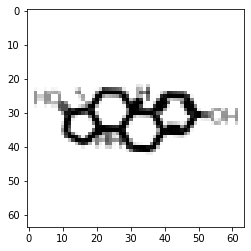

In [195]:
plt.imshow(train_x[10,:].view(64,64), cmap= "gray")

Als nächstes konvertieren Sie das Test- und Trainingsset. Denken Sie daran, dass die Dimensionen wie folgt ausehen sollen. `Anzahl Bilder, Anzahl Channel, Höhe, Breite`.

In [196]:
train_x = train_x.view(__________________________)
test_x = test_x.view(___________________________)

In [197]:
torch_train = data.TensorDataset(______________________)
train_loader = data.DataLoader(__________________, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)

torch.Size([32, 1, 64, 64]) torch.Size([32])


Wenn Sie bis jetzt alles richtig gemacht haben, sollte `batch_x` die Dimensionen `[32, 1, 64, 64]` und `batch_y` haben. Fügen Sie dem Netzwerk mindestens 2 weitere Convolution Layers hinzu. Achten Sie darauf, dass Sie auch Pooling Layers und nicht-lineare Aktivierungsfunktionen verwenden.

In [198]:
cnn = nn.Sequential(nn.Conv2d(1,3,3,1),
                   
                   
                   
                    
                   
                   
                   )

In [199]:
cnn(batch_x).shape

torch.Size([32, 12, 6, 6])

Fügen Sie nun eine `Flatten` Layer hinzu. Ab welcher Dimension fangen wir an die Werte zusammen zu fügen?

In [200]:
cnn.add_module("flatten",nn.Flatten(_))

In [201]:
cnn(batch_x).shape

torch.Size([32, 432])

Als letztes fügen Sie eine `BatchNorm`, `Dropout` und `Linear` hinzu. Achten Sie hierb auf die richitigen Input/ Output Dimensionen. 

In [210]:
cnn.add_module("bn", _______________)
cnn.add_module("dp", _______________)
cnn.add_module("fc", _______________)

In [211]:
cnn(batch_x).shape

torch.Size([32, 1])

Die `shape` solte jetzt `[32, 1]` sein. Füllen Sie den Rest des Trainingsloops aus. 

In [208]:
loss_funktion = ________________________
updaten =  torch.optim.Adam(_______________, lr =0.0003)
EPOCHS = 30


for i in range(EPOCHS):
    loss_list = [] # diese Liste speichter den Loss jedes Minibatches
    
    ___.train() 
    for minibatch in train_loader: # for-loop geht durch alle minibatches
        images, labels = minibatch # minibatch wird in Bilder und Labels geteilt
        ________.zero_grad()
        output = cnn(_______) # Forward Propagation
        loss   = loss_funktion(output.squeeze(), labels)
        loss.backward()
        loss_list.append(loss.item())
        updaten.step()
    ___.eval()    
    
    # Trainings Evaluation
    output = cnn(train_x)
    train_acc = torch.sum((output>0).squeeze().int() == train_y)/train_y.shape[0]
    # Test Evaluation
    output = cnn(test_x)
    loss   = loss_funktion(output.squeeze(), test_y)
    test_acc = torch.sum((output>0).squeeze().int() == test_y)/test_y.shape[0]
    
    print(
        "Training Loss: %.2f Training Accuracy: %.2f | Test Loss: %.2f  Test Accuracy: %.2f"
        % (np.mean(loss_list), train_acc, loss.item(),test_acc )
    )

Training Loss: 0.70 Training Accuracy: 0.59 | Test Loss: 0.68  Test Accuracy: 0.58
Training Loss: 0.67 Training Accuracy: 0.63 | Test Loss: 0.67  Test Accuracy: 0.61
Training Loss: 0.65 Training Accuracy: 0.64 | Test Loss: 0.67  Test Accuracy: 0.63
Training Loss: 0.64 Training Accuracy: 0.64 | Test Loss: 0.65  Test Accuracy: 0.61
Training Loss: 0.63 Training Accuracy: 0.67 | Test Loss: 0.64  Test Accuracy: 0.64
Training Loss: 0.62 Training Accuracy: 0.64 | Test Loss: 0.89  Test Accuracy: 0.66
Training Loss: 0.62 Training Accuracy: 0.66 | Test Loss: 0.63  Test Accuracy: 0.65
Training Loss: 0.61 Training Accuracy: 0.67 | Test Loss: 0.64  Test Accuracy: 0.65
Training Loss: 0.60 Training Accuracy: 0.69 | Test Loss: 0.62  Test Accuracy: 0.66
Training Loss: 0.60 Training Accuracy: 0.69 | Test Loss: 0.62  Test Accuracy: 0.66
Training Loss: 0.59 Training Accuracy: 0.69 | Test Loss: 0.62  Test Accuracy: 0.65
Training Loss: 0.61 Training Accuracy: 0.68 | Test Loss: 0.63  Test Accuracy: 0.64
Trai

Sie sehen, das funktioniert nur so mäßig. Mit Fingerprints hat es auf jeden Fall besser funktioniert.
Grundsätzlich ist es schwieriger CNNs zu trainieren als einfacher Neuronales Netzwerke. 
Hinzu kommt, dass die grafische Darstellung von Moleküle im Vergleich zu SMILES oder Fingerprints/Deskriptoren eine sehr ineffiziente ist. 

In unserem Fall könnte man argumentieren, dass wenn wir größere, mehr und farbige Bilder hätten, dann würde auch unser Computer besser lernen können. Dem ist wahrscheinlich auch so. Aber selbst in der Publikation von oben, konnten deren CNNs, vergleichbare Algorithmen, die Fingerprints benutzen nicht schlagen.
Man kann sagen, dass Bilder keine adäquate Repräsentation von Molekülen ist. Zumindest für das maschinelle Lernen.


Das soll nicht heißen, dass es nicht sinnvoll sein kann, CNN auf Bilder von Molekülen zu trainieren. 
Zum Beispiel Netzwerke, die Struktur erkennen und den dazugehörigen SMILES ausgeben. So können schnell Patente und chemische Veröffentlichung gescreent werden.

Wie zum Beispiel hier:
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00538-8